In [132]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, Optional

In [133]:
def config_domain(NX, NY, W, H, AXI=0):
    global NI, NJ, IDIM, JDIM, IJDIM, NIM, NJM, DX0, DY0, IR
    IR = AXI

    NI = NX
    NJ = NY
    IDIM = NI + 10
    JDIM = NJ + 10
    IJDIM = max(IDIM, JDIM)
    NIM = NI - 1
    NJM = NJ - 1

    DX0 = W / (NI - 1)
    DY0 = H / (NJ - 1)

def init_domain():
    global IDIM, JDIM, IJDIM
    global NI, NIM, NJ, NJM
    global XP, XU, YP, YV
    global DX0, DY0
    global DXP, DXU, DYP, DYV
    global RP, RU

    # DOMAIN ARRAYS
    XP = np.zeros(IDIM)
    XU = np.zeros(IDIM)

    # CONTROL VOLUME SIZE ARRAYS
    DXP = np.zeros(IDIM)
    DXU = np.zeros(IDIM)
    YP = np.zeros(JDIM)
    YV = np.zeros(JDIM)
    DYP = np.zeros(JDIM)
    DYV = np.zeros(JDIM)
    RP = np.zeros(IDIM)
    RU = np.zeros(IDIM)

    # initialize domain sizes
    for i in range(1, NI + 1):
        XU[i] = DX0 * (i - 1)

    for i in range(1, NI):
        XP[i] = (XU[i] + XU[i + 1]) / 2

    for j in range(1, NJ + 1):
        YV[j] = DY0 * (j - 1)

    for j in range(1, NJ):
        YP[j] = (YV[j] + YV[j + 1]) / 2

    XP[0] = XU[1]
    XP[NI] = XU[NI]
    YP[0] = YV[1]
    YP[NJ] = YV[NJ]

    # initialize control volume sizes
    for i in range(1, NI):
        DXP[i] = XU[i + 1] - XU[i]
    DXP[NI]=DXP[NIM]

    for i in range(1, NI + 1):
        DXU[i] = XP[i] - XP[i - 1]

    for j in range(1, NJ):
        DYP[j] = YV[j + 1] - YV[j]
    DYP[NJ]=DYP[NJM]

    for j in range(1, NJ + 1):
        DYV[j] = YP[j] - YP[j - 1]

    # initialize face dimensions
    if IR == 0:
        for i in range(1, NI + 1):
            RU[i] = 1

        for i in range(0, NI + 1):
            RP[i] = 1
    else:
        for i in range(1, NI + 1):
            RU[i] = np.fabs(XU[i])

        for i in range(0, NI + 1):
            RP[i] = np.fabs(XP[i])

def debug_domain(digit=2):
    np.set_printoptions(
        threshold=np.inf,
        precision=digit,
        suppress=True,
        linewidth=200,
    )

    print("XP: ")
    print(XP[0:NI+1])
    print("YP: ")
    print(YP[0:NJ+1])

    print("XU: ")
    print(XU[0:NI+1])
    print("YV: ")
    print(YV[0:NJ+1])

    print("DXP: ")
    print(DXP[0:NI+1])
    print("DYP: ")
    print(DYP[0:NJ+1])

    print("DXU: ")
    print(DXU[0:NI+1])
    print("DYV: ")
    print(DYV[0:NJ+1])

def set_properties(RHO0, MU0, CP0, K0, QDOT0, G0, BETA0):
    global RHO, MU, CP, K, QDOT, G, BETA
    RHO = RHO0
    MU = MU0
    CP = CP0
    K = K0
    QDOT = QDOT0
    G = G0
    BETA=BETA0

In [134]:
@dataclass
class BoundaryValues:
    N: Optional[float] = None
    S: Optional[float] = None
    E: Optional[float] = None
    W: Optional[float] = None


@dataclass
class FieldEquation:
    name: str              # Relaxation Factor
    relax: float           # Quantity
    PHI: np.ndarray = None

    # Coefficients
    AP: np.ndarray = field(default=None)
    AW: np.ndarray = field(default=None)
    AE: np.ndarray = field(default=None)
    AS: np.ndarray = field(default=None)
    AN: np.ndarray = field(default=None)

    # Boundary Cond
    BC: BoundaryValues = field(default_factory=BoundaryValues)

    # Neumann Option
    neumann: Optional[Dict[str, Optional[str]]] = None

    def __getitem__(self, idx):
        return self.PHI[idx]  # e.g., phi[i], phi[i,j]

    def __setitem__(self, idx, value):
        self.PHI[idx] = value  # e.g., phi[i,j] = value

    def __post_init__(self):
        self.PHI = np.zeros((IDIM, JDIM))
        self.AP = np.zeros((IDIM, JDIM))
        self.AW = np.zeros((IDIM, JDIM))
        self.AE = np.zeros((IDIM, JDIM))
        self.AS = np.zeros((IDIM, JDIM))
        self.AN = np.zeros((IDIM, JDIM))

In [135]:
def divideByZeroWarn(val, funcName):
    if np.abs(val) < 1e-30:
        message = "WARNING: denominator {} is zero!!".format(val)
        message += "\t FROM: {}".format(funcName)
        print(message)


def TDMA(start, end, AW, AE, AP, RHS_X):
    X = np.zeros(len(AP))
    c_prime = np.zeros(IJDIM)
    d_prime = np.zeros(IJDIM)

    denom = AP[start] + 1e-30
    divideByZeroWarn(denom, TDMA.__name__ + " start")
    c_prime[start] = AE[start] / denom
    d_prime[start] = RHS_X[start] / denom

    for i in range(start + 1, end + 1):
        denom = (AP[i] - AW[i] * c_prime[i - 1]) + 1e-30
        divideByZeroWarn(denom, TDMA.__name__ + " iter {}".format(i))
        c_prime[i] = AE[i] / denom
        d_prime[i] = (RHS_X[i] - AW[i] * d_prime[i - 1]) / denom

    X[end] = d_prime[end]

    for i in range(end - 1, start - 1, -1):
        X[i] = d_prime[i] - c_prime[i] * X[i + 1]

    return X


def LLTDMA(i_start, i_end, j_start, j_end, AW, AE, AS, AN, AP, RHS, n_iter=2):
    RHS_x = np.zeros(IDIM)
    RHS_y = np.zeros(JDIM)
    X = np.zeros((IDIM, JDIM))

    for iter in range(n_iter):
        # TDMA: x-direction
        for j in range(j_start, j_end + 1):
            for i in range(i_start, i_end + 1):
                neighbors = AS[i][j] * X[i][j - 1] + AN[i][j] * X[i][j + 1]
                RHS_x[i] = RHS[i][j] + neighbors

            X[:, j] = TDMA(i_start, i_end, -AW[:, j], -AE[:, j], AP[:, j], RHS_x)

        # TDMA: y-direction
        for i in range(i_start, i_end + 1):
            for j in range(j_start, j_end + 1):
                neighbors = AW[i][j] * X[i - 1][j] + AE[i][j] * X[i + 1][j]
                RHS_y[j] = RHS[i][j] + neighbors

            X[i, :] = TDMA(j_start, j_end, -AS[i, :], -AN[i, :], AP[i, :], RHS_y)

    return X

In [136]:
def set_BC(PHI):
    if PHI.BC.W !=0:
        for j in range(0, NJ+1):
            PHI[0][j] = PHI.BC.W  # West Wall
            PHI[1][j] = PHI.BC.W  # West Wall

    if PHI.BC.E !=0:
        for j in range(0, NJ+1):
            # PHI[NI-1][j] = PHI.BC.E  # East Wall
            PHI[NI][j] = PHI.BC.E  # East Wall
            # PHI[NI + 1][j] = PHI.BC.E  # East Wall

    if PHI.BC.S !=0:
        for i in range(0, NI+1):
            PHI[i][0] = PHI.BC.S  # South Wall
            PHI[i][1] = PHI.BC.S

    if PHI.BC.N !=0:
        for i in range(0, NI+1):
            # PHI[i][NJ-1] = PHI.BC.N
            PHI[i][NJ] = PHI.BC.N  # North Wall
            # PHI[i][NJ+1] = PHI.BC.N  # North Wall


def set_NEUMANN(PHI, flag, method="PC"):
    global AP_U, AP_V
    global PC

    if PHI.neumann is None:
        return

    if flag == "pre":
        for j in range(1, NJ):
            if PHI.neumann.get("W") == "neumann":
                PHI.AP[1][j] -= PHI.AW[1][j]
                PHI.AW[1][j] = 0

            if PHI.neumann.get("E") == "neumann":
                PHI.AP[NIM][j] -= PHI.AE[NIM][j]
                PHI.AE[NIM][j] = 0

        for i in range(1, NI):
            if PHI.neumann.get("S") == "neumann":
                PHI.AP[i][1] -= PHI.AS[i][1]
                PHI.AS[i][1] = 0

            if PHI.neumann.get("N") == "neumann":
                PHI.AP[i][NJM] -= PHI.AN[i][NJM]
                PHI.AN[i][NJM] = 0

        return

    if flag == "post":
        for j in range(1, NJ):
            if PHI.neumann.get("W") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[0][j]=PC[1][j]
                else: PHI[0][j] = PHI[1][j]

            if PHI.neumann.get("E") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[NI][j]=PC[NIM][j]
                else: PHI[NI][j] = PHI[NIM][j]

        for i in range(1, NI):
            if PHI.neumann.get("S") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[i][0]=PC[i][1]
                else:PHI[i][0] = PHI[i][1]

            if PHI.neumann.get("N") == "neumann":
                if PHI.name=="P" and method=="PC": 
                    PC[i][NJ]=PC[i][NJM]
                else: PHI[i][NJ] = PHI[i][NJM]

        return

In [137]:
def outOfRangeWarn(i, j, name):
    if i > NI or i < 0:
        print(
            "WARNING: index i={0} Out Of Range i=(0,{1})".format(i, NI)
            + "\t FROM:{}".format(name)
        )
    if j > NJ or j < 0:
        print(
            "WARNING: index j={0} Out Of Range j=(0,{1})".format(j, NJ)
            + "\t FROM:{}".format(name)
        )


def minmod(r):
    return np.fmax(0, np.fmin(1, r))


def clamp_i(ii):
    return max(0, min(ii, NI))


def clamp_j(jj):
    return max(0, min(jj, NJ))


def get_faceVal(PHI, face_vel, i, j, dir, scheme=None):  # MUSCL ALGORITHM
    if dir not in ["x", "y"]:
        raise AssertionError("dir must be 'x' or 'y'")

    if face_vel < 0:
        if dir == "x":
            u_i, u_j = (i + 1, j)
        elif dir == "y":
            u_i, u_j = (i, j + 1)
        sign = -1
    else:
        u_i, u_j = (i, j)
        sign = 1

    phi_cur = PHI[u_i][u_j]

    if dir == "x":
        # denom=PHI[u_i][u_j]-PHI[u_i-1][u_j]+1e-30
        # numer=PHI[u_i+1][u_j]-PHI[u_i][u_j]
        denom = PHI[u_i][u_j] - PHI[clamp_i(u_i - 1)][u_j] + 1e-30
        numer = PHI[clamp_i(u_i + 1)][u_j] - PHI[u_i][u_j]
        outOfRangeWarn(clamp_i(u_i + 1), u_j, get_faceVal.__name__)
        outOfRangeWarn(clamp_i(u_i - 1), u_j, get_faceVal.__name__)
    else:
        # denom=PHI[u_i][u_j]-PHI[u_i][u_j-1]+1e-30
        # numer=PHI[u_i][u_j+1]-PHI[u_i][u_j]
        denom = PHI[u_i][u_j] - PHI[u_i][clamp_j(u_j - 1)] + 1e-30
        numer = PHI[u_i][clamp_j(u_j + 1)] - PHI[u_i][u_j]
        outOfRangeWarn(u_i, clamp_j(u_j + 1), get_faceVal.__name__)
        outOfRangeWarn(u_i, clamp_j(u_j - 1), get_faceVal.__name__)

    # divideByZeroWarn(denom,get_faceVal.__name__)
    r = numer / denom
    return phi_cur + 0.5 * sign * denom * minmod(r)


def get_RES(PHI):
    global U, V
    global RHS, RES
    global method

    alpha=method["ALPHA"]

    # b: Flux Coeff
    if PHI.name == "T":
        b = RHO * CP
    elif PHI.name in ["U", "V"]:
        b = RHO

    for i in range(1, NI):
        for j in range(1, NJ):
            # advection terms
            # upwind criteria (faced flux)
            if PHI.name == "T":
                uw = U[i][j]
                ue = U[i + 1][j]
                vs = V[i][j]
                vn = V[i + 1][j]
            elif PHI.name == "U":
                uw = 0.5 * (U[i][j] + U[i - 1][j])
                ue = 0.5 * (U[i][j] + U[i + 1][j])
                vs = 0.5 * (V[i - 1][j] + V[i][j])
                vn = 0.5 * (V[i - 1][j + 1] + V[i][j + 1])
            elif PHI.name == "V":
                uw = 0.5 * (U[i][j - 1] + U[i][j])
                ue = 0.5 * (U[i + 1][j - 1] + U[i + 1][j])
                vs = 0.5 * (V[i][j] + V[i][j - 1])
                vn = 0.5 * (V[i][j] + V[i][j + 1])

            # b: advection coeff
            if PHI.name == "T":
                b = RHO * CP
            elif PHI.name in ["U", "V"]:
                b = RHO

            # carrier flux (important)
            Fw = b * RU[i] * DYP[j] * uw
            Fe = b * RU[i + 1] * DYP[j] * ue
            Fs = b * RP[i] * DXP[i] * vs
            Fn = b * RP[i] * DXP[i] * vn

            # high-resolution scheme (MUSCL)
            # upwind face value
            upwind_w = get_faceVal(PHI, uw, i - 1, j, "x")
            upwind_e = get_faceVal(PHI, ue, i, j, "x")
            upwind_s = get_faceVal(PHI, vs, i, j - 1, "y")
            upwind_n = get_faceVal(PHI, vn, i, j, "y")

            x_advect_HO = Fe * upwind_e - Fw * upwind_w
            y_advect_HO = Fn * upwind_n - Fs * upwind_s

            x_advect_LO = (
                (np.fmax(0, Fe) * PHI[i][j] + np.fmax(0, -Fe) * PHI[i + 1][j])
                - (np.fmax(0, Fw) * PHI[i - 1][j] + np.fmax(0, -Fw) * PHI[i][j])
            )

            y_advect_LO = (
                (np.fmax(0, Fn) * PHI[i][j] + np.fmax(0, -Fn) * PHI[i][j + 1])
                - (np.fmax(0, Fs) * PHI[i][j - 1] + np.fmax(0, -Fs) * PHI[i][j])
            )

            x_advect = x_advect_HO - x_advect_LO
            y_advect = y_advect_HO - y_advect_LO
            advect = x_advect + y_advect

            # alpha = 1  # blending factor

            # SOU = FOU + advect * alpha
            # residual & correction
            # RES[i][j] = RHS[i][j] - SOU
            RES[i][j] = RHS[i][j] - alpha * advect

    # print("advect SOU - FOU = {}".format(advect))
    return RES

def sub_iterate(PHI,itmax=1):
    global iter
    global sub_iter

    for sub_iter in range(itmax):
        RES = get_RES(PHI)
        CORR = LLTDMA(1, NIM, 1, NJM, PHI.AW, PHI.AE, PHI.AS, PHI.AN, PHI.AP, RHS=RES)

        sl = (slice(1, NI), slice(1, NJ))
        FFMAX = max(1.0e-30, np.max(np.abs(PHI[sl])))
        RESMAX = np.max(np.abs(RES[sl] / PHI.AP[sl])) / FFMAX
        FCMAX = np.max(np.abs(CORR[sl])) / FFMAX

        for i in range(1, NI):
            for j in range(1, NJ):
                # PHI[i][j] += PHI.relax * CORR[i][j]
                PHI[i][j] += CORR[i][j] # URF
        
        set_NEUMANN(PHI, "post")
    
    return (RESMAX, FCMAX)

def SOLVE(PHI):
    global is_solve
    global U, V, P
    global RHS
    global NI, NJ, NIM, NJM
    global QDOT, RHO, CP, K0, MU0
    global method

    
    if method["RHO"]!="CONST" and is_solve["T"]==True:
        is_NC=True
        global T
    else: 
        is_NC=False


    if PHI.name not in ["U", "V", "T"]:
        AssertionError("FieldEquation name must be U, V, P, T")

    is_solve[PHI.name] = True

    # TDMA coeffs
    for i in range(1, NI):
        for j in range(1, NJ):

            if PHI.name == "T":
                a=K
            elif PHI.name in ["U","V"]:
                a=MU
            AW_diff = a * RU[i] * DYP[j] / DXU[i]
            AE_diff = a * RU[i + 1] * DYP[j] / DXU[i + 1]
            AS_diff = a * RP[i] * DXP[i] / DYV[j]
            AN_diff = a * RP[i] * DXP[i] / DYV[j + 1]
            


            # LHS_diffusion
            # if PHI.name == "T":
            #     AW_diff = K * RU[i] * DYP[j] / DXU[i]
            #     AE_diff = K * RU[i + 1] * DYP[j] / DXU[i + 1]
            #     AS_diff = K * RP[i] * DXP[i] / DYV[j]
            #     AN_diff = K * RP[i] * DXP[i] / DYV[j + 1]
            # elif PHI.name == "U":
            #     AW_diff = MU * RU[i] * DYP[j] / DXP[i]
            #     AE_diff = MU * RU[i + 1] * DYP[j] / DXP[i + 1]
            #     AS_diff = MU * RP[i] * DXU[i] / DYV[j]
            #     AN_diff = MU * RP[i] * DXU[i] / DYV[j + 1]
            # elif PHI.name == "V":
            #     AW_diff = MU * RU[i] * DYV[j] / DXU[i]
            #     AE_diff = MU * RU[i + 1] * DYV[j] / DXU[i + 1]
            #     AS_diff = MU * RP[i] * DXP[i] / DYP[j]
            #     AN_diff = MU * RP[i] * DXP[i] / DYP[j + 1]

            # advection terms
            # upwind criteria (faced flux)
            if PHI.name == "T":
                uw = U[i][j]
                ue = U[i + 1][j]
                vs = V[i][j]
                vn = V[i + 1][j]
            elif PHI.name == "U":
                uw = 0.5 * (U[i][j] + U[i - 1][j])
                ue = 0.5 * (U[i][j] + U[i + 1][j])
                vs = 0.5 * (V[i - 1][j] + V[i][j])
                vn = 0.5 * (V[i - 1][j + 1] + V[i][j + 1])
            elif PHI.name == "V":
                uw = 0.5 * (U[i][j - 1] + U[i][j])
                ue = 0.5 * (U[i + 1][j - 1] + U[i + 1][j])
                vs = 0.5 * (V[i][j] + V[i][j - 1])
                vn = 0.5 * (V[i][j] + V[i][j + 1])

            # b: advection coeff
            if PHI.name == "T":
                b = RHO * CP
            elif PHI.name in ["U", "V"]:
                b = RHO

            # carrier flux (important)
            Fw = b * RU[i] * DYP[j] * uw
            Fe = b * RU[i + 1] * DYP[j] * ue
            Fs = b * RP[i] * DXP[i] * vs
            Fn = b * RP[i] * DXP[i] * vn

            # LHS = LHS_diffusion + LHS_advection
            PHI.AW[i][j] = AW_diff + np.fmax(0, +Fw)
            PHI.AE[i][j] = AE_diff + np.fmax(0, -Fe)
            PHI.AS[i][j] = AS_diff + np.fmax(0, +Fs)
            PHI.AN[i][j] = AN_diff + np.fmax(0, -Fn)
            PHI.AP[i][j] = (
                PHI.AW[i][j]
                + PHI.AE[i][j]
                + PHI.AS[i][j]
                + PHI.AN[i][j]
            )
            
            # RHS: regarded as "answer", latest updated
            ## UnderRelaxtionFactor due to finer grid
            PHI.AP[i][j]/=PHI.relax
            if PHI.name == "T":
                RHS[i][j] = QDOT * RP[i] * DXP[i] * DYP[j]
            elif PHI.name == "U":
                RHS[i][j] = -(P[i][j] - P[i - 1][j]) * DYP[j] # core advantage of STAGGERED-GRID
            elif PHI.name == "V":
                RHS[i][j] = -(P[i][j] - P[i][j - 1]) * DXP[i]
                if is_NC==True: 
                    RHS[i][j] += DXP[i] * DYV[j] * RHO * G * BETA * T[i][j]
            RHS[i][j] += (1. - PHI.relax) * PHI.AP[i][j] * PHI[i][j]
            
            neighbors = (
                PHI.AW[i][j] * PHI[i - 1][j]
                + PHI.AE[i][j] * PHI[i + 1][j]
                + PHI.AS[i][j] * PHI[i][j - 1]
                + PHI.AN[i][j] * PHI[i][j + 1]
            )
            FOU = PHI.AP[i][j] * PHI[i][j] - neighbors
            RHS[i][j] -= FOU

    # boundary conds
    set_NEUMANN(PHI, "pre")

    ###################### debugging ######################
    global is_debug
    global iter, JUMP
    if is_debug["PHI"]==True and iter%JUMP==0:  
        # print("{}.AW".format(PHI.name))
        # print(PHI.AW[1:NI,1:NJ])
        # print("{}.AE".format(PHI.name))
        # print(PHI.AE[1:NI,1:NJ])
        # print("{}.AS".format(PHI.name))
        # print(PHI.AS[1:NI,1:NJ])
        # print("{}.AN".format(PHI.name))
        # print(PHI.AN[1:NI,1:NJ])
        print("{}.AP".format(PHI.name))
        print(PHI.AP[1:NI, 1:NJ])
        print("{}".format(PHI.name))
        print(PHI.PHI[1:NI, 1:NJ])
    ###################### debugging ######################

    # RES = get_RES(PHI)
    # CORR = LLTDMA(1, NIM, 1, NJM, PHI.AW, PHI.AE, PHI.AS, PHI.AN, PHI.AP, RHS=RES)

    # sl = (slice(1, NI), slice(1, NJ))
    # FFMAX = max(1.0e-30, np.max(np.abs(PHI[sl])))
    # RESMAX = np.max(np.abs(RES[sl] / PHI.AP[sl])) / FFMAX
    # FCMAX = np.max(np.abs(CORR[sl])) / FFMAX

    # for i in range(1, NI):
    #     for j in range(1, NJ):
    #         # PHI[i][j] += PHI.relax * CORR[i][j]
    #         PHI[i][j] += CORR[i][j] # URF


    # set_NEUMANN(PHI, "post")

    (RESMAX, FCMAX)=sub_iterate(PHI,1)

    return (RESMAX, FCMAX)

In [138]:
def PROJECT(flag, method="PC"):
    global U, V, P
    global AP_U, AP_V
    global PC

    if flag == "pre":
        if method=="PC": return
        for j in range(1, NJ):
            # for i in range(1, NI+1):
            for i in range(1, NI):
                U[i][j] += AP_U[i][j] * (P[i][j] - P[i - 1][j]) / DXU[i]
            # U[0][j] += AP_U[1][j]*(P[1][j]-P[0][j])/DXU[1]

        for i in range(1, NI):
            # for j in range(1, NJ+1):
            for j in range(1, NJ):    
                V[i][j] += AP_V[i][j] * (P[i][j] - P[i][j - 1]) / DYV[j]
            # V[i][0] += AP_V[i][1]*(P[i][1]-P[i][0])/DYV[1]

    elif flag == "post":
        for j in range(1, NJ):
            # for i in range(1, NI+1):
            for i in range(1, NI):
                if method=="PC": U[i][j] -= AP_U[i][j] * (PC[i][j] - PC[i - 1][j]) / DXU[i]
                else: U[i][j] -= AP_U[i][j] * (P[i][j] - P[i - 1][j]) / DXU[i]
            # U[0][j] -= AP_U[1][j]*(P[1][j]-P[0][j])/DXU[1]

        for i in range(1, NI):
            # for j in range(1, NJ+1):
            for j in range(1, NJ):
                if method=="PC": V[i][j] -= AP_V[i][j] * (PC[i][j] - PC[i][j - 1]) / DYV[j]
                else: V[i][j] -= AP_V[i][j] * (P[i][j] - P[i][j - 1]) / DYV[j]
            # V[i][0] -= AP_V[i][1]*(P[i][1]-P[i][0])/DYV[1]


def SOLVE_P():
    global is_solve
    global U, V, P
    global RHS, RES
    global AP_U, AP_V
    global PC
    global method

    U_method=method["U"]
    V_method=method["V"]
    P_method=method["P"]

    AP_U = np.zeros((IDIM, JDIM))
    AP_V = np.zeros((IDIM, JDIM))
    PC = np.zeros((IDIM,JDIM))

    if U_method not in ["SIMPLE", "SIMPLEC"] or V_method not in ["SIMPLE", "SIMPLEC"]:
        AssertionError(
            "U,V method must be [SIMPLE, SIMPLEC] but U_method:{0} V_method:{1} given".format(U_method,V_method)
            )

    # remove old pressure correction
    for i in range(1, NI):
        for j in range(1, NJ):
            if U_method == "SIMPLE":
                AP_U[i][j] = RP[i] * DYP[j] * DXU[i] / (U.AP[i][j] * U.relax)
            elif U_method == "SIMPLEC":
                neibors_u = (U.AE[i][j]+ U.AW[i][j]+ U.AN[i][j]+ U.AS[i][j])
                AP_U[i][j] = RP[i] * DYP[j] * DXU[i] / (U.AP[i][j] * U.relax - neibors_u)
            if V_method == "SIMPLE":
                AP_V[i][j] = RU[i] * DXP[i] * DYV[j] / (V.AP[i][j] * V.relax)
            elif V_method == "SIMPLEC":
                neibors_v = (V.AE[i][j]+ V.AW[i][j]+ V.AN[i][j]+ V.AS[i][j])
                AP_V[i][j] = RU[i] * DXP[i] * DYV[j] / (V.AP[i][j] * V.relax - neibors_v)

            AP_U[0][j]  = AP_U[1][j]
            AP_U[NI][j] = AP_U[NIM][j]
            AP_V[0][j]  = AP_V[1][j]
            AP_V[NI][j] = AP_V[NIM][j]
    
        AP_U[i][0]  = AP_U[i][1]
        AP_U[i][NJ] = AP_U[i][NJM]
        AP_V[i][0]  = AP_V[i][1]
        AP_V[i][NJ] = AP_V[i][NJM]

    for i in range(1, NI):
        for j in range(1, NJ):

            P.AW[i][j] = (AP_U[i][j]) * RU[i] * DYP[j] / DXU[i]
            P.AE[i][j] = (AP_U[i + 1][j]) * RU[i + 1] * DYP[j] / DXU[i + 1]
            P.AS[i][j] = (AP_V[i][j]) * RP[i] * DXP[i] / DYV[j]
            P.AN[i][j] = (AP_V[i][j + 1]) * RP[i] * DXP[i] / DYV[j + 1]

            P.AP[i][j] = P.AW[i][j] + P.AE[i][j] + P.AS[i][j] + P.AN[i][j]

    if P_method !="PC": PROJECT(flag="pre",method="")

    ###################### debugging ######################
    global is_debug
    global iter, JUMP
    if is_debug["PHI"]==True and iter%JUMP==0:  
        print("P")
        print(P.PHI[1:NI, 1:NJ])
        print("AP_U")
        print(AP_U[1:NI, 1:NJ])
        print("AP_V")
        print(AP_V[1:NI, 1:NJ])
        print("P.AP")
        print(P.AP[1:NI, 1:NJ])
    ###################### debugging ######################

    set_NEUMANN(P, "pre")

    for i in range(1, NI):
        for j in range(1, NJ):
            # 0.5*(V[i-1][j]+V[i][j])
            # 0.5*(V[i-1][j+1]+V[i][j+1])

            Fw = RU[i] * DYP[j] * U[i][j]
            Fe = RU[i + 1] * DYP[j] * U[i + 1][j]
            Fs = RP[i] * DXP[i] * V[i][j]
            Fn = RP[i] * DXP[i] * V[i][j + 1]

            RHS[i][j] = Fw - Fe + Fs - Fn

            neighbors = (
                P.AW[i][j] * P[i - 1][j]
                + P.AE[i][j] * P[i + 1][j]
                + P.AS[i][j] * P[i][j - 1]
                + P.AN[i][j] * P[i][j + 1]
            )

            if P_method=="PC": RES[i][j] = RHS[i][j]
            else: RES[i][j] = RHS[i][j] - (P.AP[i][j] * P[i][j] - neighbors)

    ###################### debugging ######################
    if is_debug["PHI"]==True and iter%JUMP==0: 
        
        print("P: RES/AP")
        print(RES[1:NI, 1:NJ] / P.AP[1:NI, 1:NJ])
    ###################### debugging ######################

    if P_method =="PC": PC=LLTDMA(1, NIM, 1, NJM, P.AW, P.AE, P.AS, P.AN, P.AP, RHS=RES, n_iter=3)
    else: CORR = LLTDMA(1, NIM, 1, NJM, P.AW, P.AE, P.AS, P.AN, P.AP, RHS=RES, n_iter=3)
    
    
    if P_method=="PC": 
        set_NEUMANN(P, "post",method=P_method)
        CORR=PC

    for i in range(1, NI):
        for j in range(1, NJ):
            P[i][j] += P.relax * CORR[i][j]
    
    if P_method=="PC": 
        set_NEUMANN(P, "post",method="")
    else: 
        set_NEUMANN(P, "post",method=P_method)

    PROJECT(flag="post",method=P_method)

    if P_method!="PC": 
        for j in range (1,NJ):
            for i in range(1,NI):
                neighbors = (
                    P.AW[i][j] * P[i - 1][j]
                    + P.AE[i][j] * P[i + 1][j]
                    + P.AS[i][j] * P[i][j - 1]
                    + P.AN[i][j] * P[i][j + 1]
                )
                RES[i][j]=RHS[i][j]-(P[i][j]*P.AP[i][j]-neighbors)
    
			
    sl = (slice(1, NI), slice(1, NJ))
    FFMAX = max(1.0e-30, np.max(np.abs(P[sl])))
    RESMAX = np.max(np.abs(RES[sl] / P.AP[sl])) / FFMAX
    FCMAX = np.max(np.abs(CORR[sl])) / FFMAX

    return (RESMAX, FCMAX)

In [ ]:
def config_solver(jump=100, errmax=1e-6):
    global JUMP, ERRMAX
    JUMP = jump
    ERRMAX = errmax

def monitor_RES(iter, res):
    global is_solve
    global U, V, P, T
    global JUMP, ERRMAX

    is_continue = 1
    ref_id = (NI//2, NJ//2)

    resmax = max(res[0][0], res[1][0], res[2][0], res[3][0])
    fcmax = max(res[0][1], res[1][1], res[2][1], res[3][1])

    message = "iter= {:4d}".format(iter)
    message_sub=""
    if is_solve.get("U"):
        message += " U= {:11.3e}".format(U[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_U= {:11.3e}".format(res[0][0])+" FCMAX_U= {:11.3e}".format(res[0][1])
    if is_solve.get("V"):
        message += " V= {:11.3e}".format(V[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_V= {:11.3e}".format(res[1][0])+" FCMAX_V= {:11.3e}".format(res[1][1])
    if is_solve.get("P"):
        message += " P= {:11.3e}".format(P[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_P= {:11.3e}".format(res[2][0])+" FCMAX_P= {:11.3e}".format(res[2][1])
    if is_solve.get("T"):
        message += " T= {:11.3e}".format(T[ref_id])
        if is_debug["RES"]==True:
            message_sub+=" RES_T= {:11.3e}".format(res[3][0])+" FCMAX_T= {:11.3e}".format(res[3][1])

    message += " ResMax= {:11.3e} Fcmax= {:11.3e}".format(resmax, fcmax)

    if iter % JUMP == 0:
        print(message)
        if is_debug["RES"]==True:
            print(message_sub)

    if iter and resmax < ERRMAX and fcmax < ERRMAX:
        print(message)
        if is_debug["RES"]==True:
            print(message_sub)
        print(" CONVERGENCE ACHIEVED!! ")
        is_continue = 0

    return is_continue


def SOLVE_ALL(max_iter=1000):
    global U, V, P, T
    global iter

    iter = 0
    RES_U = (0, 0)
    RES_V = (0, 0)
    RES_P = (0, 0)
    RES_T = (0, 0)

    for iter in range(max_iter):
        
        if is_solve.get("U"): RES_U = SOLVE(U)
        if is_solve.get("V"): RES_V = SOLVE(V)
        if is_solve.get("P"): RES_P = SOLVE_P()
        if is_solve.get("T"): RES_T = SOLVE(T)

        RES_ALL=(RES_U, RES_V, RES_P, RES_T)

        if monitor_RES(iter, RES_ALL) == 0:
            break


In [140]:
def get_StreamFunc(refU,refV):

    SF=np.zeros((IDIM,JDIM))
    for j in range(1,NJ):
        SF[1][j+1]=SF[1][j]+0.5*(refU[1][j]+refV[0][j])*DYP[j]
    for j in range(1,NJ):
        for i in range(1,NI):
            SF[i+1][j]=SF[i][j]-0.5*(refV[i][j]+refV[i][j-1])*RP[i]*DXP[i]

    return SF

def plot_results(PHI, title):
    x_coords = XP[1:NI]
    y_coords = YP[1:NJ]
    PHI_data = PHI[1:NI, 1:NJ]

    X_plot, Y_plot = np.meshgrid(x_coords, y_coords)
    PHI_plot = PHI_data.T

    if isinstance(PHI,FieldEquation)==False: label=title
    elif PHI.name == "T": label="Temperature"
    elif PHI.name == "U": label="U (x-directional velocity)"
    elif PHI.name == "V": label="V (y-directional velocity)"

    plt.figure(figsize=(8, 6))
    contour_fill = plt.contourf(X_plot, Y_plot, PHI_plot, levels=15, cmap='jet')
    contour_lines = plt.contour(
        X_plot,
        Y_plot,
        PHI_plot,
        levels=15,
        colors='black',
        linewidths=0.5,
    )
    plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    plt.title(f'{title} ({NIM}x{NJM} Grid)')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.colorbar(contour_fill, label=label)
    plt.axis('equal')
    plt.show()


def activate_debug():
    global is_debug
    np.set_printoptions(
        threshold=np.inf,
        precision=8,
        suppress=True,
        linewidth=200,
    )

In [144]:
#------------------------------CASE1------------------------------#
is_solve = {"P": True, "U": True, "V": True, "T": False}
is_debug = {"PHI": False, "RES": False}
method = {"U":"SIMPLE","V":"SIMPLE","P":"PC","RHO":"CONST","ALPHA":1}

config_domain(NX=10, NY=40, W=5e-3, H=1)
init_domain()

RHS = np.zeros((IDIM, JDIM))
RES = np.zeros((IDIM, JDIM))

config_solver(jump=50, errmax=1e-5)
set_properties(RHO0=100, MU0=0.001, CP0=1000, K0=1, QDOT0=0, G0=9.81, BETA0=1.e-2)

U = FieldEquation(
    name="U",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={},
    relax=0.8,
)

V = FieldEquation(
    name="V",
    BC=BoundaryValues(W=0, E=0, S=0.1, N=0),
    neumann={"N": "neumann", "W": "neumann"},
    relax=0.8,
)

P = FieldEquation(
    name="P",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={"S": "neumann", "W": "neumann", "E": "neumann"},
    relax=0.6,
)

U0 = 0
V0 = 0

U.PHI[:] = 0.0
V.PHI[:] = 0.0  
P.PHI[:] = 0.0

set_BC(U)
set_BC(V)
set_BC(P)

# debug_domain(3)
SOLVE_ALL(max_iter=1000)


iter=    0 U=   9.577e-10 V=   3.601e-06 P=   4.213e-04 ResMax=   3.321e-02 Fcmax=   1.667e+00
iter=   50 U=  -2.614e-05 V=   1.218e-01 P=   3.587e+00 ResMax=   1.246e-02 Fcmax=   3.051e-02
iter=  100 U=  -2.303e-06 V=   1.163e-01 P=   6.484e+00 ResMax=   1.414e-03 Fcmax=   1.104e-02
iter=  150 U=   1.524e-06 V=   1.113e-01 P=   6.001e+00 ResMax=   3.437e-04 Fcmax=   2.199e-03
iter=  200 U=  -9.927e-09 V=   1.121e-01 P=   5.930e+00 ResMax=   1.065e-04 Fcmax=   2.508e-04
iter=  250 U=  -6.603e-08 V=   1.123e-01 P=   5.963e+00 ResMax=   2.930e-06 Fcmax=   1.293e-04
iter=  300 U=   8.746e-09 V=   1.122e-01 P=   5.962e+00 ResMax=   5.621e-06 Fcmax=   1.353e-05
iter=  308 U=  -1.063e-09 V=   1.122e-01 P=   5.962e+00 ResMax=   4.244e-06 Fcmax=   9.849e-06
 CONVERGENCE ACHIEVED!! 


9
9


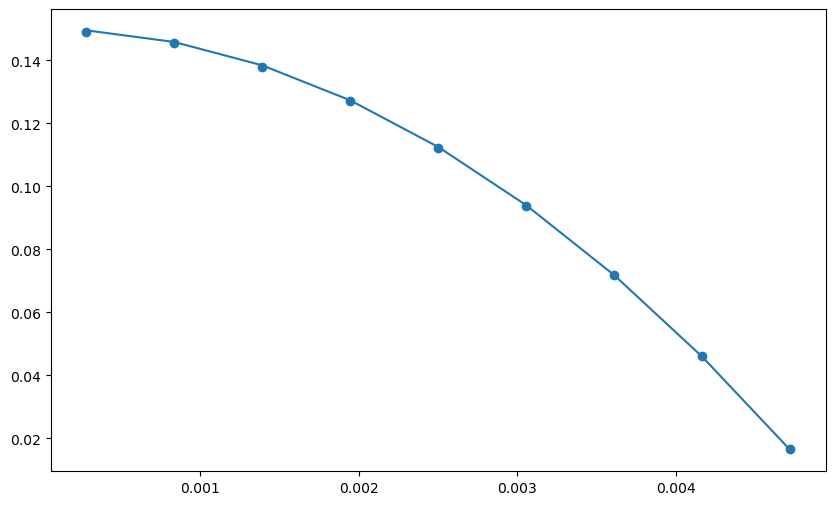

In [145]:
Vex = np.zeros(IDIM)
for i in range(0, NI+1):
   Vex[i] = 0.1*1.5*(1-XP[i]*XP[i]/XP[NI]/XP[NI])

i_range = range(1, NI)
j_range = range(1, NJ)

print(len(Vex[i_range]))
print(len(XP[i_range]))

plt.figure(figsize=(10,6))
plt.plot(XP[i_range],Vex[i_range])
plt.scatter(XP[i_range],V.PHI[i_range,39])
# plt.scatter(YP[j_range],P.PHI[5,j_range])

In [143]:
#------------------------------CASE1------------------------------#
is_solve = {"P": True, "U": True, "V": True, "T": True}
is_debug = {"PHI": False, "RES": True}
method = {"U":"SIMPLE","V":"SIMPLE","P":"PC","RHO":"","ALPHA":0}

config_domain(NX=20, NY=20, W=0.1, H=0.1)
init_domain()

RHS = np.zeros((IDIM, JDIM))
RES = np.zeros((IDIM, JDIM))

config_solver(jump=50, errmax=1e-5)
set_properties(RHO0=1, MU0=0.71e-4, CP0=1e2, K0=1e-2, QDOT0=0, G0=9.81, BETA0=1.e-2)

Ra = 1.e4
DT = Ra / 1.382e4

U = FieldEquation(
    name="U",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={},
    relax=0.8,
)

V = FieldEquation(
    name="V",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={},
    relax=0.8,
)

P = FieldEquation(
    name="P",
    BC=BoundaryValues(W=0, E=0, S=0, N=0),
    neumann={"S": "neumann", "W": "neumann", "E": "neumann", "N": "neumann"},
    relax=0.6,
)

T = FieldEquation(
    name="T",
    BC=BoundaryValues(W=0.5*DT, E=-0.5*DT, S=0, N=0),
    neumann={"S": "neumann", "N": "neumann"},
    relax=1,
)

U0 = 0
V0 = 0

U.PHI[:] = 0.0
V.PHI[:] = 0.0  
P.PHI[:] = 0.0

set_BC(U)
set_BC(V)
set_BC(P)
set_BC(T)

SOLVE_ALL(max_iter=1000)


iter=    0 U=  -1.038e-06 V=  -3.354e-06 P=  -7.265e-08 T=   3.174e-03 ResMax=   2.216e+27 Fcmax=   3.566e+27
 RES_U=   0.000e+00 FCMAX_U=   0.000e+00 RES_V=   2.216e+27 FCMAX_V=   3.566e+27 RES_P=   5.422e-01 FCMAX_P=   1.667e+00 RES_T=   5.000e-01 FCMAX_T=   8.670e-01
iter=   50 U=   1.841e-03 V=   7.508e-04 P=  -9.439e-04 T=   6.888e-02 ResMax=   1.899e-03 Fcmax=   2.155e-02
 RES_U=   2.785e-05 FCMAX_U=   1.188e-04 RES_V=   1.540e-05 FCMAX_V=   5.624e-05 RES_P=   1.899e-03 FCMAX_P=   2.155e-02 RES_T=   7.600e-06 FCMAX_T=   9.329e-05
iter=  100 U=   1.848e-03 V=   7.559e-04 P=  -1.629e-03 T=   6.905e-02 ResMax=   1.156e-03 Fcmax=   1.305e-02
 RES_U=   5.511e-08 FCMAX_U=   2.204e-07 RES_V=   3.377e-08 FCMAX_V=   1.422e-07 RES_P=   1.156e-03 FCMAX_P=   1.305e-02 RES_T=   1.515e-08 FCMAX_T=   1.506e-07


KeyboardInterrupt: 

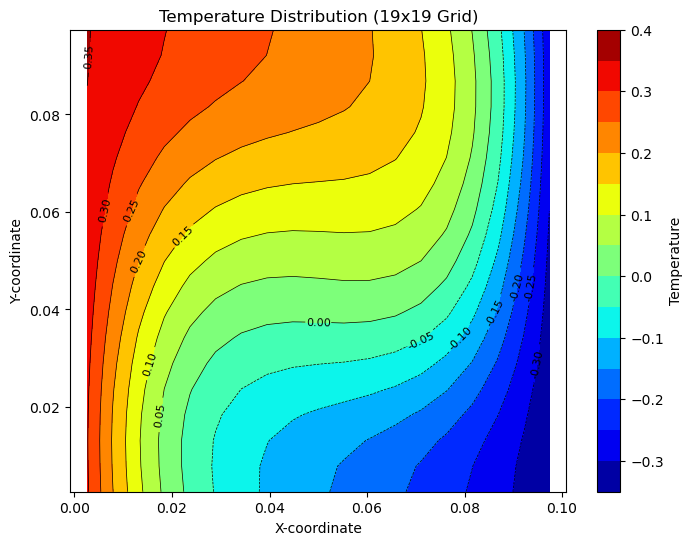

In [ ]:
plot_results(T, title="Temperature Distribution")

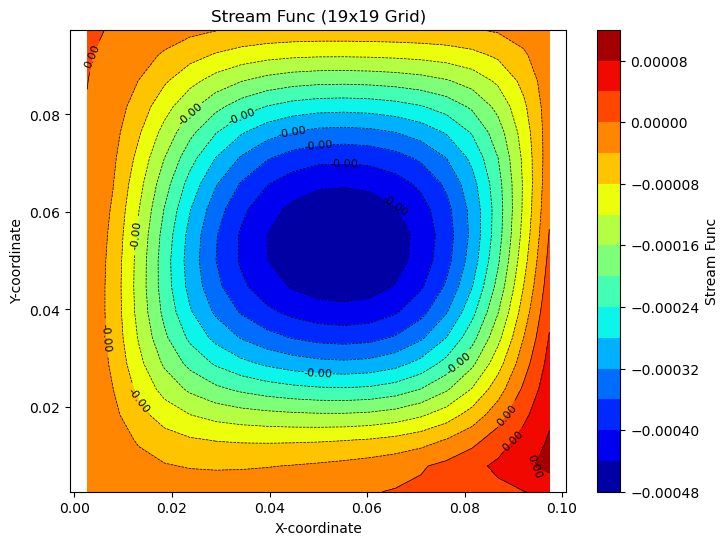

In [ ]:
SF=get_StreamFunc(U,V)
plot_results(SF, title="Stream Func")

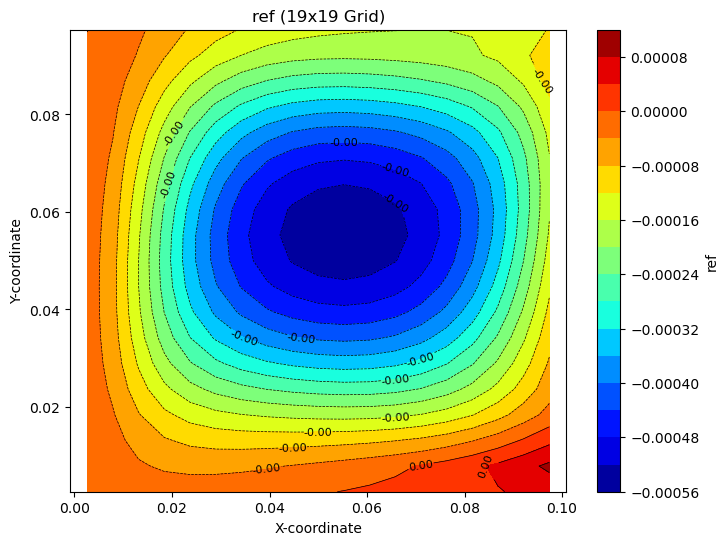

In [ ]:
REFU=np.loadtxt("out_U")
REFV=np.loadtxt("out_V")
SF_REF=get_StreamFunc(REFU,REFV)
plot_results(SF_REF,"ref")

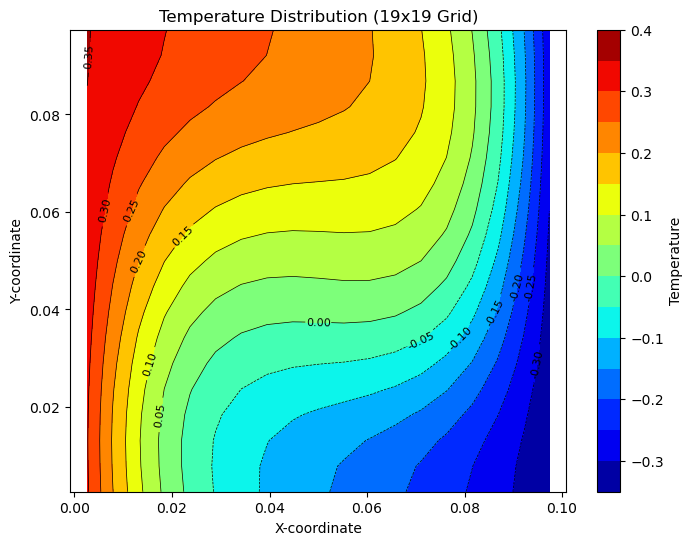

In [ ]:
plot_results(T, title="Temperature Distribution")

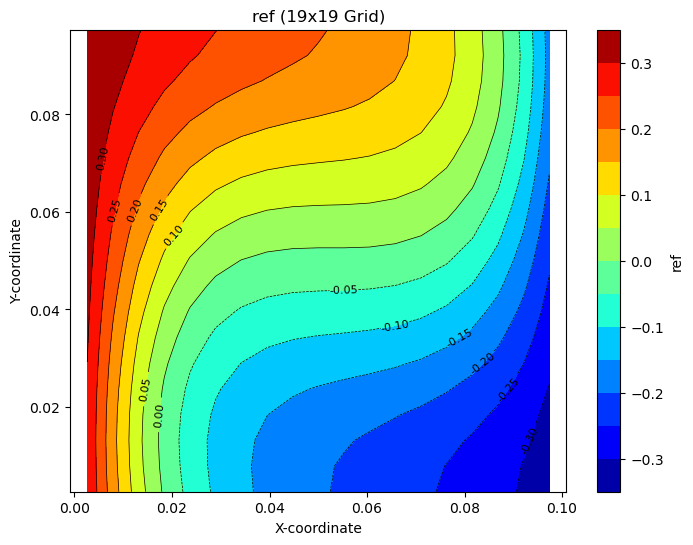

In [ ]:
REFT=np.loadtxt("out_T")
plot_results(REFT, title="ref")